https://neuromechfly.org/tutorials/cpg_controller.html


In [4]:
import numpy as np

def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_freqs : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amps : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators.
        High magnitudes and unfortunate phases might cause physics error
        """
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = np.zeros(self.num_cpgs)
        else:
            self.curr_magnitudes = init_magnitudes

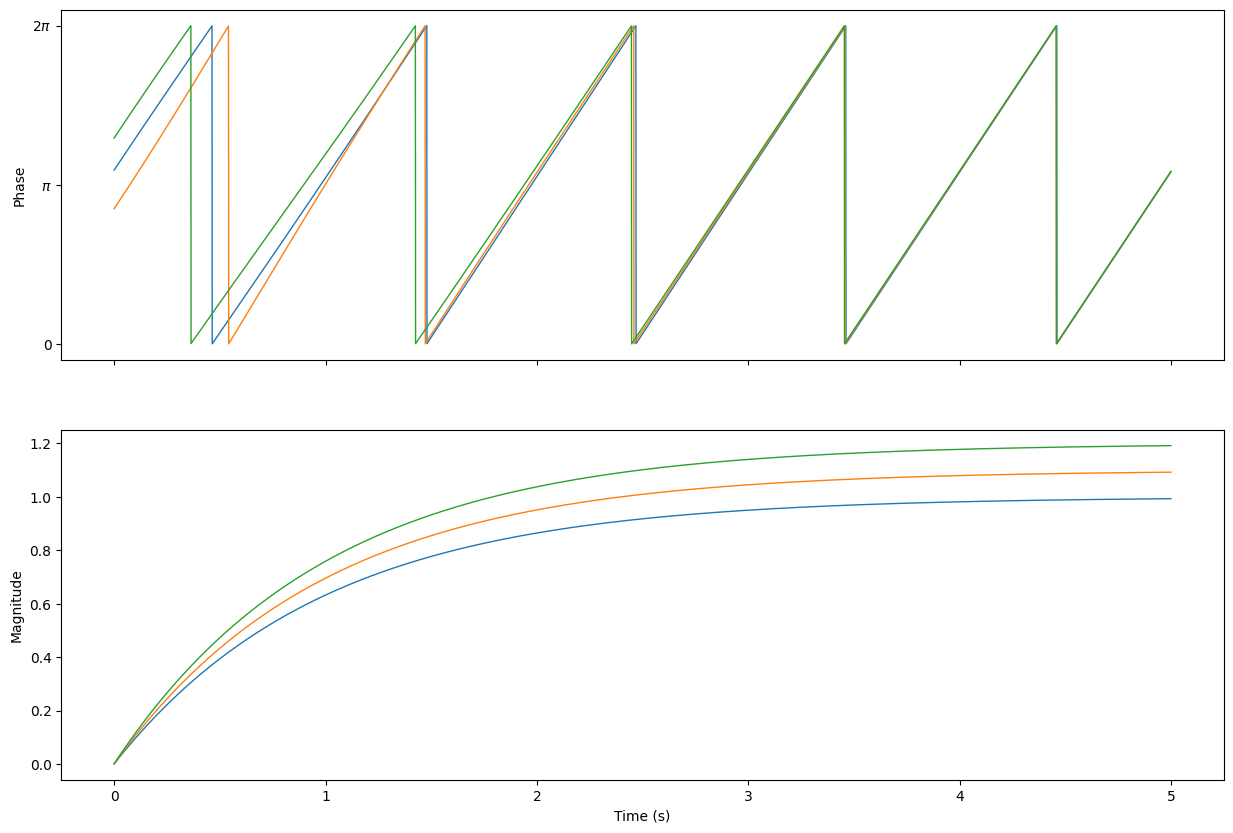

In [7]:
intrinsic_freqs = np.ones(3)
intrinsic_amps = np.array([1.0, 1.1, 1.2])
coupling_weights = np.array(
    [
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ]
)
phase_biases = np.deg2rad(
    np.array(
        [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ]
    )
)
convergence_coefs = np.ones(3)

network = CPGNetwork(
    timestep=1e-3,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

num_steps = int(5 / network.timestep)
phase_hist = np.empty((num_steps, 3))
magnitude_hist = np.empty((num_steps, 3))

# Simulate the network
network.reset()
for i in range(num_steps):
    network.step()
    phase_hist[i, :] = network.curr_phases
    magnitude_hist[i, :] = network.curr_magnitudes

from pathlib import Path
import matplotlib.pyplot as plt

output_dir = Path("./outputs/cpg_controller")
output_dir.mkdir(exist_ok=True, parents=True)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
t = np.arange(num_steps) * network.timestep
axs[0].plot(t, phase_hist % (2 * np.pi), linewidth=1)
axs[0].set_yticks([0, np.pi, 2 * np.pi])
axs[0].set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
axs[0].set_ylabel("Phase")
axs[1].plot(t, magnitude_hist, linewidth=1)
axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Time (s)")
fig.savefig(output_dir / "simple_cpg_rollout.png")
    

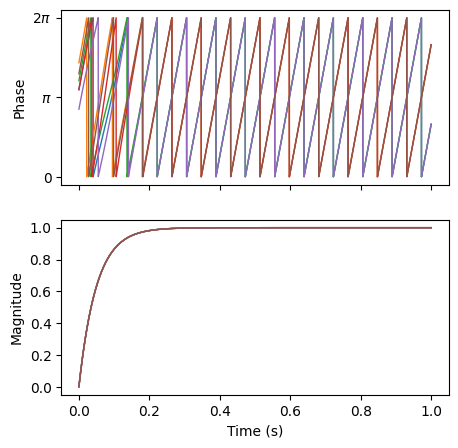

In [19]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

# Simulate the network
num_steps = int(1 / network.timestep)
phase_hist = np.empty((num_steps, 6))
magnitude_hist = np.empty((num_steps, 6))
for i in range(num_steps):
    network.step()
    phase_hist[i, :] = network.curr_phases
    magnitude_hist[i, :] = network.curr_magnitudes

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
t = np.arange(num_steps) * network.timestep
axs[0].plot(t, phase_hist % (2 * np.pi), linewidth=1)
axs[0].set_yticks([0, np.pi, 2 * np.pi])
axs[0].set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
axs[0].set_ylabel("Phase")
axs[1].plot(t, magnitude_hist, linewidth=1)
axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Time (s)")
fig.savefig(output_dir / "tripod_cpg_rollout.png")

Preprogrammed steps have a length of 45 steps at dt=0.003s.


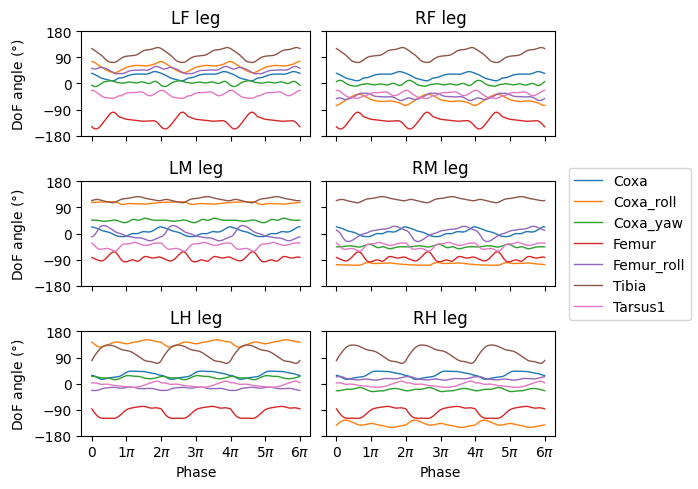

In [20]:
import pickle
from flygym.util import get_data_path

single_steps_path = (
    get_data_path("flygym", "data") / "behavior/single_steps_untethered.pkl"
)
with open(single_steps_path, "rb") as f:
    single_steps_data = pickle.load(f)


preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]
print(
    f"Preprogrammed steps have a length of {preprogrammed_steps_length} steps "
    f"at dt={preprogrammed_steps_timestep}s."
)
for k, v in single_steps_data.items():
    if k.startswith("joint_"):
        assert len(v) == preprogrammed_steps_length
        assert v[0] == v[-1]

from scipy.interpolate import CubicSpline

legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
    "Coxa",
    "Coxa_roll",
    "Coxa_yaw",
    "Femur",
    "Femur_roll",
    "Tibia",
    "Tarsus1",
]
phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
psi_funcs = {}
for leg in legs:
    joint_angles = np.array(
        [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
    )
    psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")


theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    joint_angles_by_leg[leg] = psi_func(theta_ts)

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "three_steps_phase_only.png")


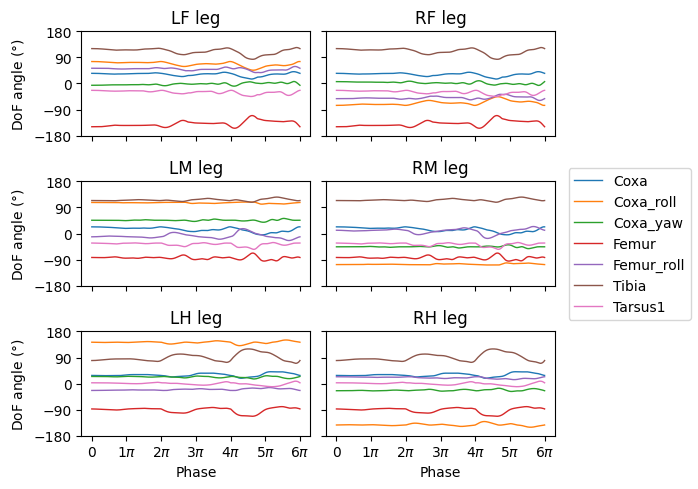

In [21]:
theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)
r_ts = np.linspace(0, 1, 10000)

##### THIS SECTION HAS CHANGED #####
joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    neutral_pos = psi_func(0)[:, np.newaxis]
    joint_angles_by_leg[leg] = neutral_pos + r_ts * (psi_func(theta_ts) - neutral_pos)
####################################

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "three_steps_amp_modulated.png")

In [22]:
from flygym import Fly, Camera, SingleFlySimulation
from flygym.preprogrammed import all_leg_dofs

run_time = 1
fly = Fly(init_pose="stretch", actuated_joints=all_leg_dofs, control="position")
cam = Camera(fly=fly, play_speed=0.1, draw_contacts=False)
sim = SingleFlySimulation(fly=fly, cameras=[cam], timestep=1e-4)

intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 1000

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=1,
)

swing_start = np.empty(6)
swing_end = np.empty(6)
for i, leg in enumerate(legs):
    swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
    swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_start *= 2 * np.pi
swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_end *= 2 * np.pi

# have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
psi_rest_phases = np.ones_like(swing_start)
for i, leg in enumerate(legs):
    psi_rest_phases[i] = (swing_end[i] + 2 * np.pi) / 2

##

from tqdm import trange

obs, info = sim.reset()
for _ in trange(int(run_time / sim.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    action = {"joints": np.array([joints_angles[dof] for dof in fly.actuated_joints])}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "cpg_controller.mp4", 0)

100%|██████████| 10000/10000 [00:29<00:00, 338.00it/s]
